In [ ]:
# install.packages(c("recommenderlab", "dplyr", "ggplot2", "ggridges", "tidyr", "coop", "gridExtra", "reshape2"))

Installing packages into 'C:/Users/vince/Documents/R/win-library/3.6'
(as 'lib' is unspecified)


In [125]:
library(recommenderlab)
library(dplyr)
library(ggplot2)
library(ggridges)
library(tidyr)
library(coop)
library(gridExtra)
library(reshape2)

Warning message:
"package 'reshape2' was built under R version 3.6.3"
Attaching package: 'reshape2'

The following object is masked from 'package:tidyr':

    smiths



Aufgabe: Reduziere den MovieLense Datensatz auf rund 400 Kunden 
und 700 Filme, indem du Filme und Kunden  mit sehr wenigen Ratings 
entfernst.
Untersuche und dokumentiere die Eigenschaften des reduzierten 
Datensatzes und beschreibe den Effekt der Datenreduktion:
  1.Anzahl Filme und Kunden sowie Sparsity vor und nach Datenreduktion

In [2]:
data(MovieLense)
MovieLense_df <- as(MovieLense, "data.frame")
MovieLenseMeta_df <- as(MovieLenseMeta, "data.frame")
MOVIE_MIN_RATED = 700
USER_MIN_RATED = 400
SEED = 42
set.seed(SEED)

movies_min_rated <- MovieLense_df %>%
  count(item) %>%
  arrange(desc(n)) %>%
  head(MOVIE_MIN_RATED) %>%
  select(item)

MovieLense_user_movies_reduced_df <- MovieLense_df %>%
  inner_join(movies_min_rated, by='item')

user_min_movies_rated <- MovieLense_user_movies_reduced_df %>%
  count(user) %>%
  arrange(desc(n)) %>%
  head(USER_MIN_RATED) %>%
  select(user)

MovieLense_user_movies_reduced_df <- MovieLense_user_movies_reduced_df %>%
  inner_join(user_min_movies_rated, by='user') 

Movie_Genre <- MovieLenseMeta %>%
  pivot_longer(cols=c(unknown:Western)) %>%
  filter(value==1) %>% 
  rename(genre = name)

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"

IBCF run fold/sample [model time/prediction time]
	 1  [1.82sec/0.06sec] 


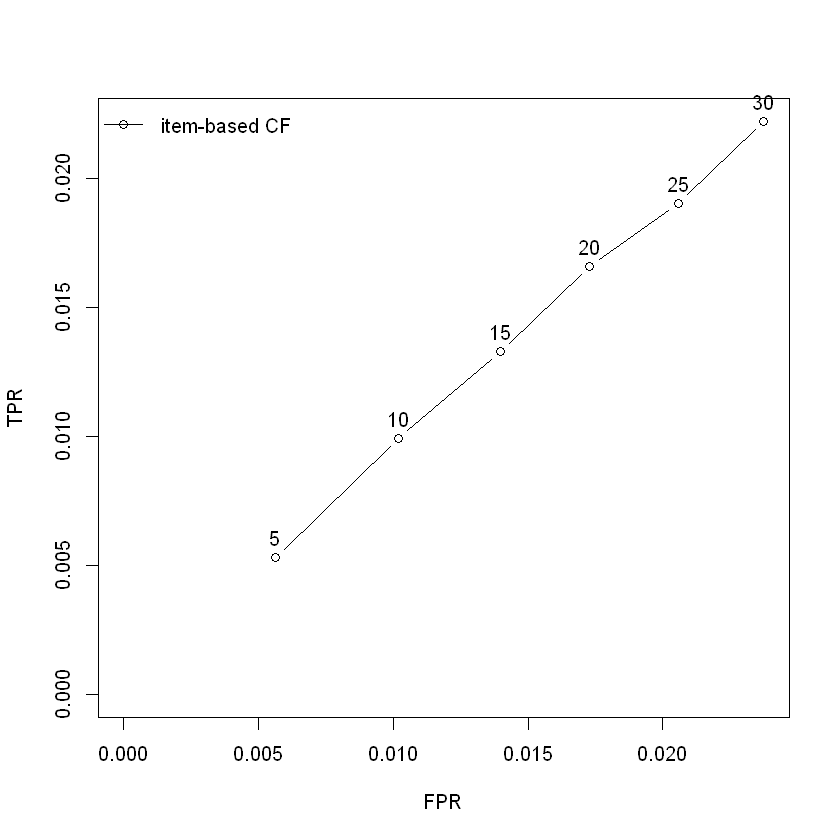

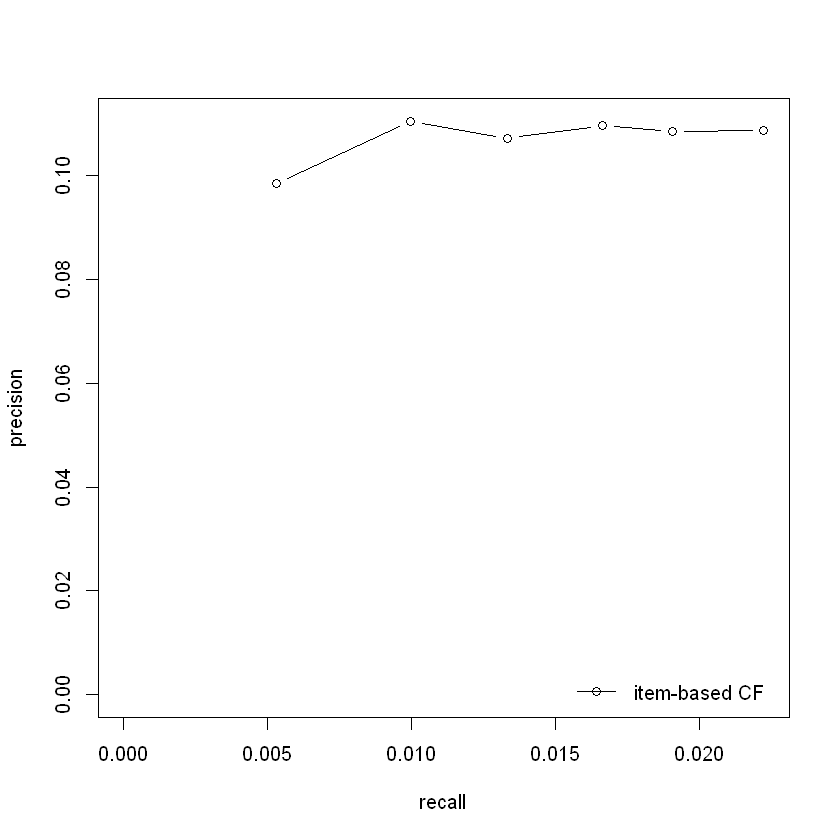

In [3]:
set.seed(SEED)
# Let's check some algorithms against each other
scheme <- recommenderlab::evaluationScheme(coerce(MovieLense_user_movies_reduced_df,MovieLense) , method = "split", train = 0.8,
                          given = 3, goodRating = 4)


algorithms <- list(
  "item-based CF" = list(name="IBCF", param=list(normalize = "Z-score"))
  )

# run algorithms, predict next n movies
n = c(5, 10, 15, 20, 25, 30)
results <- evaluate(scheme, algorithms, n=n)

# Draw ROC curve
plot(results, annotate = 1:4, legend="topleft")

# See precision / recall
plot(results, "prec/rec", annotate=3)

In [11]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)


IBCF_reduced <- Recommender(data = getData(eval_reduced, "train"), method = "IBCF", 
                            parameter = list(k = 30, method = "Cosine", na_as_zero=TRUE))


Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"

In [12]:
top_n_to_df <- function(top_n){
  #' @description Function to transform a TopNList object to a data.frame object.
  #' @param topn Topn List
  topn_df <- data.frame(user = names(as(top_n, 'list')), 
    rating = unlist(top_n@ratings), index = unlist(top_n@items))

  topn_df$item <- top_n@itemLabels[topn_df$index]
  topn_df$year <- MovieLenseMeta$year[topn_df$index]
  topn_df <- topn_df[order(topn_df$user),]
  topn_df
}

calc_coverage <- function(top_n, n_movies=1664){
  #' @description Function, which returns coverage 
  #' @param top_n Top_n list generated by `recommenderlab::predict`
  #' @param n_movies How many total movies there are. In the MovielenseDB, there are 1664 Movies.
  top_n = as(top_n, 'list')
  unique_pred_movies = unique(unlist(top_n, recursive = FALSE))
  n_unique_pred_movies = length(unique_pred_movies)
    
  return (n_unique_pred_movies / n_movies)
}

calc_popularity <- function(MovieLenseData, n_movies=1664){
  #' @description Function, which returns coverage as described here: https://ds-spaces.technik.fhnw.ch/6rsy/2021/05/02/recommender-system-evaluierung-coverage-und-novelty/
  #' @param MovieLenseData Movielense data.frame, containing how a user has rated a movie.
  #' @param n_movies How many total movies there are. In the MovielenseDB, there are 1664 Movies.
  
  popularity_movie <- MovieLenseData %>%
    count(item) %>%
    mutate(popularity = log2(n / n_movies)) %>%
    select(item, popularity)
  return (popularity_movie)
  
}
calc_novelty <- function(top_n, MovieLenseData, n_movies=1664){
  #' @description Function, which returns novelty as described here: https://ds-spaces.technik.fhnw.ch/6rsy/2021/05/02/recommender-system-evaluierung-coverage-und-novelty/
  #' @param top_n Top_n list generated by `recommenderlab::predict`
  #' @param MovieLenseData MovieLense Dataset as data.frame
  #' @param n_movies How many total movies there are. In the MovielenseDB, there are 1664 Movies.
  popularity = calc_popularity(MovieLenseData, n_movies) 
  
  top_n_df <- top_n_to_df(top_n)
    
  group_size_user = top_n_df %>%
    group_by(user) %>%
    summarise(n = n()) %>%
    select(user, n)
  
  top_n_df <- top_n_df %>%
    left_join(group_size_user, by = 'user')
  
  top_n_popularity_df <- top_n_df %>%
    inner_join(popularity, by = 'item') %>%
    mutate(popularity = popularity / n)
  
  novelty = sum(top_n_popularity_df$popularity)
  
  S = length(unique(MovieLenseData$user))
  
  novelty = - 1 / S * novelty
  
  return (novelty)
}

In [13]:
top_n = predict(object = IBCF_reduced, newdata = getData(eval_reduced, "unknown"), n = 15)

In [14]:
calc_coverage(top_n)
calc_novelty(top_n, MovieLense_df)

[1] 0.3082933

[1] 0.3566119

In [15]:
# Test coverage and novelty on 5, 10, 15, 20, 25 and 30 top_n predictions.
n_list = c(5, 10, 15, 20, 25)

for(n in n_list){
    IBCF_reduced <- Recommender(data = getData(eval_reduced, "train"), method = "IBCF", 
                            parameter = list(method = "Cosine", na_as_zero=TRUE))
    
    top_n = predict(object = IBCF_reduced, newdata = getData(eval_reduced, "unknown"), n = n)
    print(paste("N: ", n))
    print(paste("Coverage: ", calc_coverage(top_n)))
    print(paste("Novelty: ", calc_novelty(top_n, MovieLense_df)))
}


[1] "N:  5"
[1] "Coverage:  0.150841346153846"
[1] "Novelty:  0.36566404904635"
[1] "N:  10"
[1] "Coverage:  0.246394230769231"
[1] "Novelty:  0.360403937068437"
[1] "N:  15"
[1] "Coverage:  0.308293269230769"
[1] "Novelty:  0.356611864879244"
[1] "N:  20"
[1] "Coverage:  0.341947115384615"
[1] "Novelty:  0.356017022268193"
[1] "N:  25"
[1] "Coverage:  0.365384615384615"
[1] "Novelty:  0.354361922543304"


In [16]:
avg_to_df <- function(evlist, n){
  #' @description gets the confusion matices from `evlist` and transforms it to a single data.frame
  #' @param evlist evaluationResultList
  #' @return data.frame confusion matrix with all recommenders as rec and number of recommendations as n
  evaluation_avg <- data.frame()
  for (i in 1:length(evlist)){
    current_avg <- as.data.frame(avg(evlist[i]))
    colnames(current_avg) <- c('TP','FP','FN','TN','N', 'precision','recall','TPR','FPR', 'n')
    current_avg$specificity <- current_avg$TN * (current_avg$TN + current_avg$FP)**-1
    current_avg$n <- n
    rownames(current_avg) <- NULL
    current_avg$rec <- names(evlist)[i]
    evaluation_avg <- rbind(evaluation_avg, current_avg)
  }
  return(evaluation_avg)
}
plot_percision_recall <- function(evaluation_avg){
  #' @description plots the percision recall curve with the according number of predictions
  #' @param evaluation_avg data.frame from avg_to_df
  ggplot(evaluation_avg, aes(x=precision, y=recall, label=n)) +
    geom_line(aes(color=rec)) +
    geom_text() +
    scale_color_manual(values=1:length(evaluation_avg)) +
    ggtitle('Precision Recall Curve') +
    xlab('precision') +
    ylab('recall')
}


In [17]:
avg_to_df(results, n)

TP,FP,FN,TN,N,precision,recall,TPR,FPR,n,specificity,rec
0.4000,3.3500,96.1875,597.0625,697,0.09846154,0.005305618,0.005305618,0.005618535,25,0.9944205,item-based CF
0.8500,6.1125,95.7375,594.3000,697,0.11045177,0.009939166,0.009939166,0.010197076,25,0.9898195,item-based CF
1.1375,8.4125,95.4500,592.0000,697,0.10719554,0.013302795,0.013302795,0.013989640,25,0.9859888,item-based CF
1.4375,10.4250,95.1500,589.9875,697,0.10956059,0.016604964,0.016604964,0.017285140,25,0.9826369,item-based CF
1.6750,12.4375,94.9125,587.9750,697,0.10848366,0.019053207,0.019053207,0.020581792,25,0.9792851,item-based CF
1.9250,14.3750,94.6625,586.0375,697,0.10870838,0.022222742,0.022222742,0.023750453,25,0.9760581,item-based CF


## Implementierung Top-N Monitor
Aufgabe DIY: Untersuche die relative Übereinstimmung zwischen Top-
N Empfehlungen und präferierten Filmen für 4 unterschiedliche 
Modelle (z.B. IBCF und UBCF mit unterschiedlichen  Ähnlichkeits-
metriken / Nachbarschaften sowie SVD mit unterschiedlicher 
Dimensionalitätsreduktion).

### 1.Fixiere 20 zufällig gewählte Testkunden für alle Modellvergleiche

In [23]:
set.seed(SEED)
random_user_idx = floor(runif(20, min=0, max=nrow(getData(eval_reduced, "unknown"))+1))
test_user_selected = getData(eval_reduced, "unknown")[random_user_idx]

### 2.Bestimme den Anteil der Top-N Empfehlung nach Genres pro Kunde
Zuerst schauen wir, basierend auf Precision, Recall, Novelty und Coverage, welche Modelle überhaupt interessant sind.

In [34]:
# Random Users:
set.seed(42)
test = getData(eval_reduced, "unknown")
n = c(5, 10, 15, 20, 25, 30) # How many movies should be predicted (top n).

algorithms <- list(
    "IBCF, z-score, cos" = list(name="IBCF", param=list(normalize = "Z-score",
                                                   method = 'cosine')),
    "IBCF, z-score, jac" = list(name="IBCF", param=list(normalize = "Z-score",
                                                   method = 'jaccard')),
    "IBCF, center, cos" = list(name="IBCF", param=list(normalize = "center",
                                                 method = 'cosine')),
    "IBCF, center, jac" = list(name="IBCF", param=list(normalize = "center",
                                                 method = 'jaccard')),
    "UBCF, z-score, cos" = list(name="UBCF", param=list(normalize = "Z-score",
                                                   method = 'cosine')),
    "UBCF, z-score, jac" = list(name="UBCF", param=list(normalize = "Z-score",
                                                   method = 'jaccard')),
    "UBCF, center, cos" = list(name="UBCF", param=list(normalize = "center",
                                                 method = 'cosine')),
    "UBCF, center, jac" = list(name="UBCF", param=list(normalize = "center",
                                                       method = 'jaccard')), 
    "SVD, 2" = list(name='SVD', param=list(k=2)),
    "SVD, 5" = list(name='SVD', param=list(k=5)),
    "SVD, 10" = list(name='SVD', param=list(k=10)),
    "SVD, 20" = list(name='SVD', param=list(k=20))
)


Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"

IBCF run fold/sample [model time/prediction time]
	 1  [1.5sec/0.02sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [1.4sec/0.02sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [1.46sec/0sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [1.36sec/0.02sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.01sec/0.14sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0.02sec/0.15sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.27sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.14sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.02sec/0.05sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.01sec/0.05sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.02sec/0.03sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.05sec/0.05sec] 


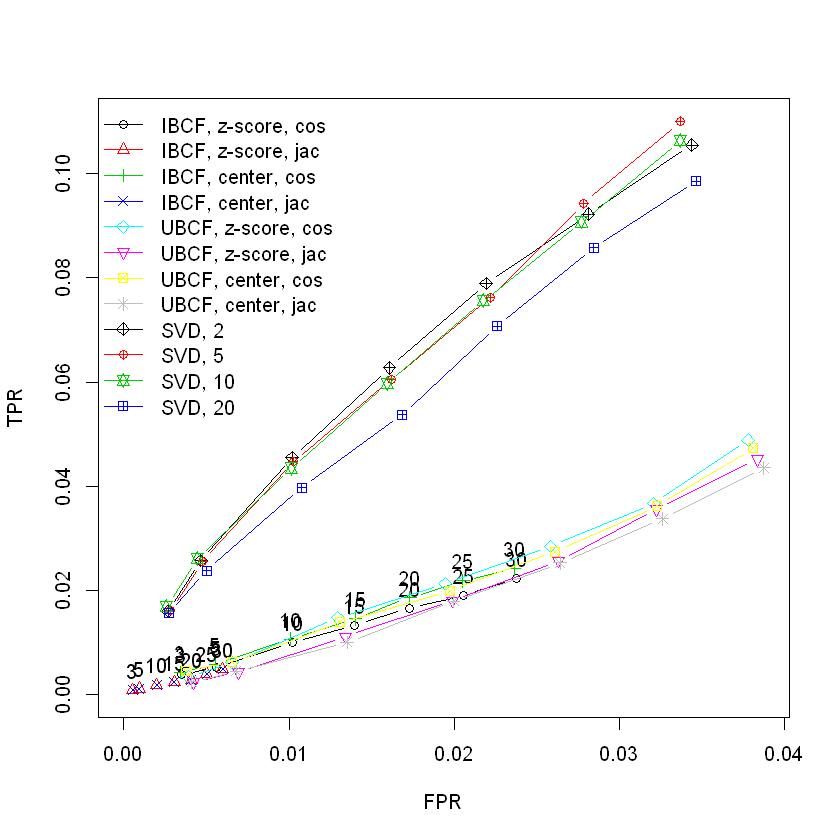

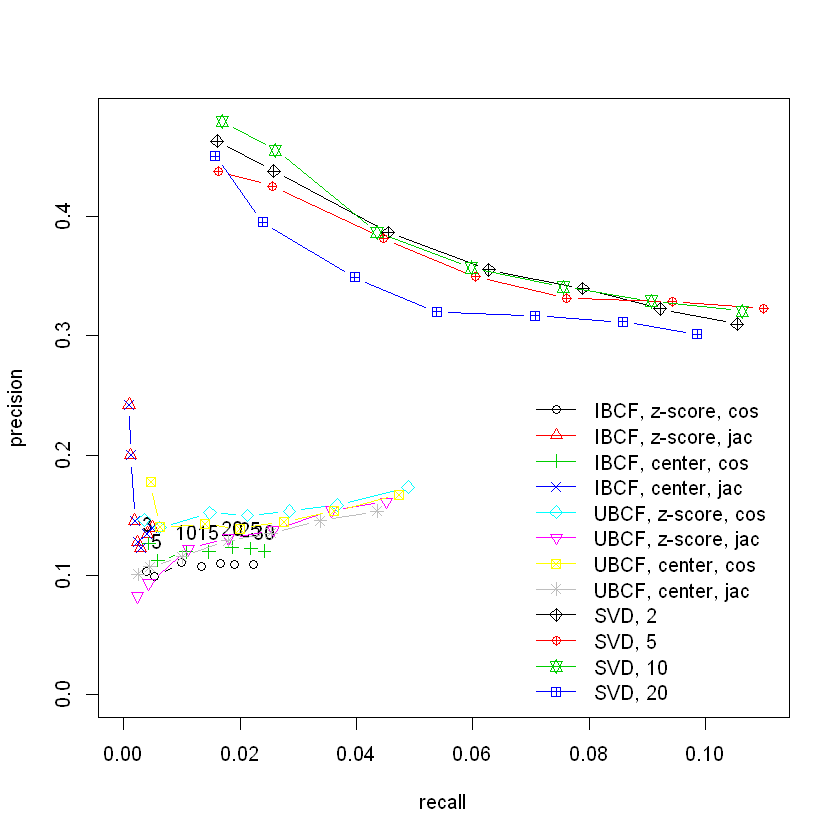

In [35]:
set.seed(SEED)
# Let's check some algorithms against each other
scheme <- recommenderlab::evaluationScheme(coerce(MovieLense_user_movies_reduced_df,MovieLense) , method = "split", train = 0.8,
                          given = 3, goodRating = 4)


# run algorithms, predict next n movies
n = c(3, 5, 10, 15, 20, 25, 30)
results <- evaluate(scheme, algorithms, n=n)

# Draw ROC curve
plot(results, annotate = 1:4, legend="topleft")

# See precision / recall
plot(results, "prec/rec", annotate=3)

In [76]:
top_n_genres <- function(top_n, Movie_Genre, col_name){
    #' @algorithms top_n generated by recommenderlab::predict
    #' @Movie_Genre Movie_Genre melted MovieLenseData, containing at least the genre and the title of a movie
    #' @col_name name for copy of percentages of genres (for easier comparison between different models).
    #' @returns genres of users in the top_n list
    top_n = top_n_to_df(top_n)
    Movie_Genre$item = Movie_Genre$title
    genres_top_n <- top_n %>%
        left_join(Movie_Genre, by='item') %>%
        group_by(user, genre)  %>%
        summarise(n = n()) %>% 
        mutate(percent =  100 *n/sum(n))
    genres_top_n[,col_name] = genres_top_n$percent
    return (genres_top_n)
}

In [130]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)


recommender <- Recommender(data = getData(eval_reduced, "train"), method = "IBCF", 
                            parameter = list( method = "Cosine", na_as_zero=TRUE))

top_n = predict(recommender, test_user_selected, n=15)

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"

In [131]:
IBCF_top_genre = top_n_genres(top_n, Movie_Genre, 'IBCFCos')

`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


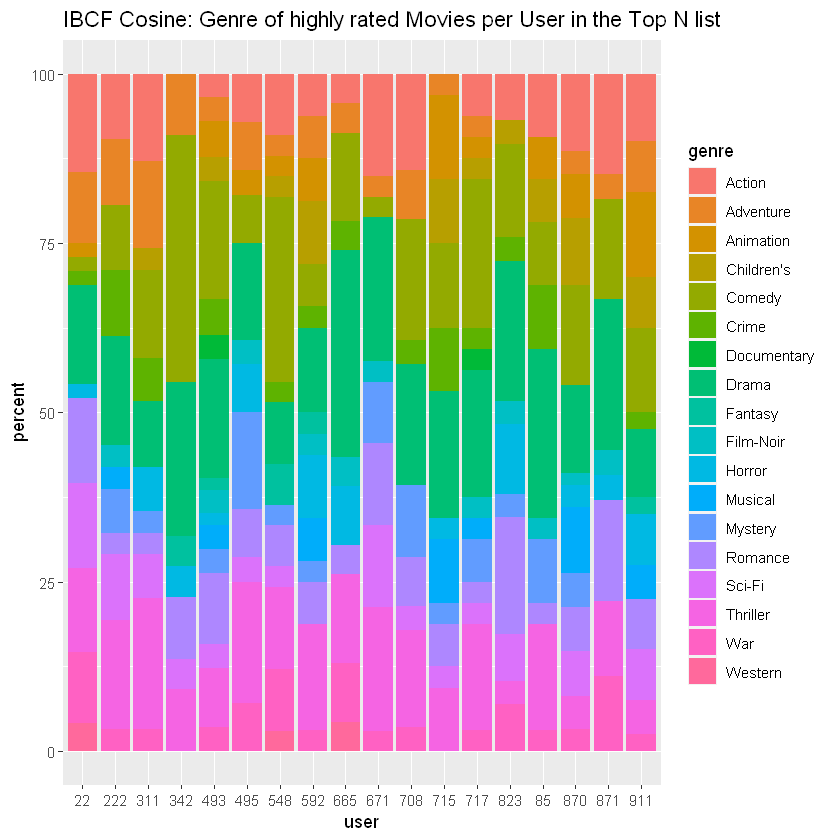

In [132]:
ggplot(IBCF_top_genre, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "IBCF Cosine: Genre of highly rated Movies per User in the Top N list")

In [133]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)

recommender <- Recommender(data = getData(eval_reduced, "train"), method = "UBCF", 
                            parameter = list(nn = 25, method = "Cosine"))

top_n = predict(recommender, test_user_selected, n=15)
UBCF_cos_top_genre = top_n_genres(top_n, Movie_Genre, 'UBCFCos')

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


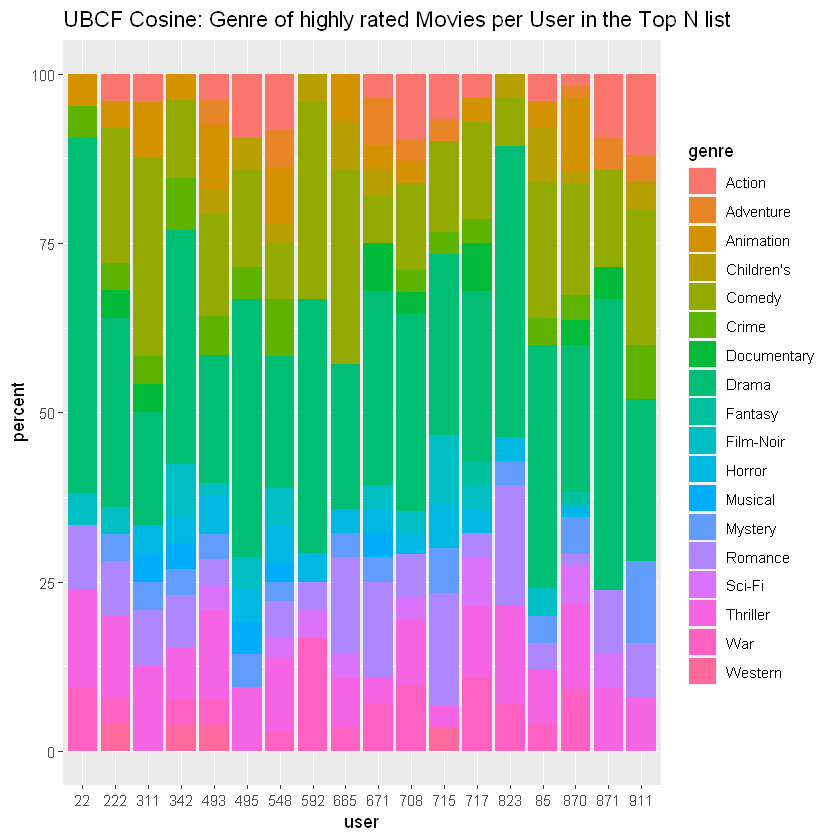

In [134]:
ggplot(UBCF_cos_top_genre, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "UBCF Cosine: Genre of highly rated Movies per User in the Top N list")

In [135]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)


recommender <- Recommender(data = getData(eval_reduced, "train"), method = "UBCF", 
                            parameter = list(nn = 25, method = "Jaccard"))

top_n = predict(recommender, test_user_selected, n=15)
UBCF_jacc_top_n_genre = top_n_genres(top_n, Movie_Genre, 'UBCFJacc')

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


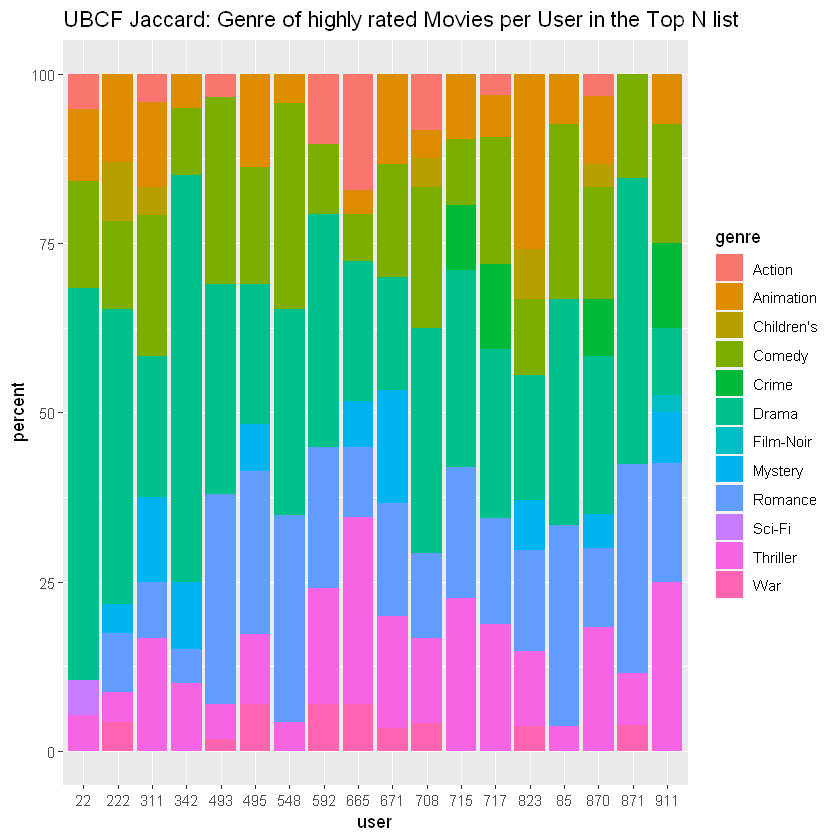

In [136]:
ggplot(UBCF_jacc_top_n_genre, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "UBCF Jaccard: Genre of highly rated Movies per User in the Top N list")

In [137]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)


recommender <- Recommender(data = getData(eval_reduced, "train"), method = "SVD", 
                            parameter = list(k = 5))

top_n = predict(recommender, test_user_selected, n=15)
SVD_5_top_n_genre = top_n_genres(top_n, Movie_Genre, 'SVD5')

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


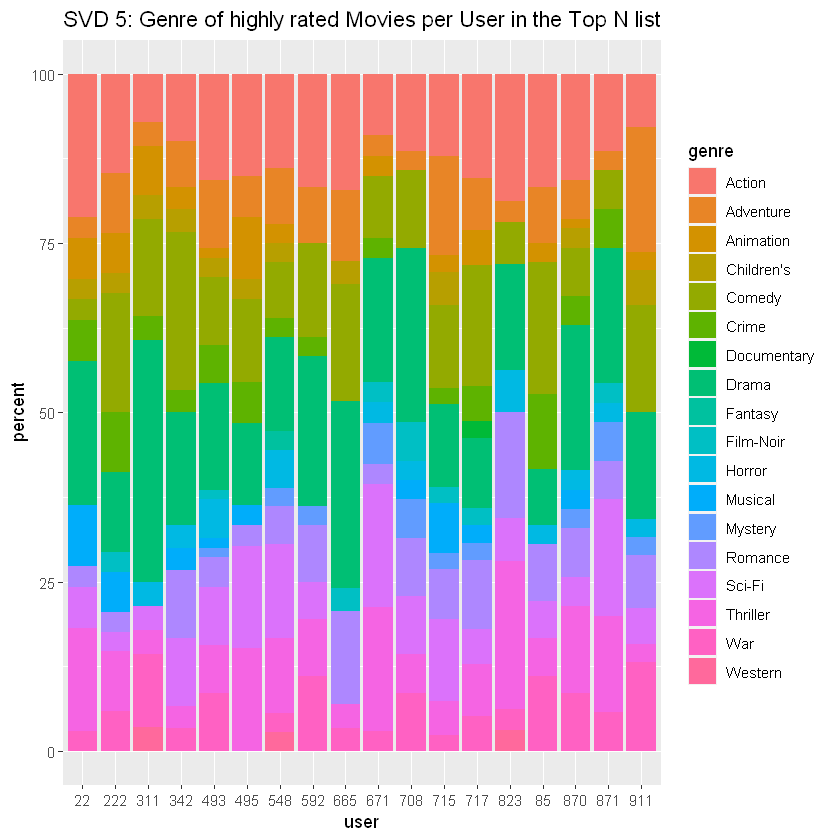

In [138]:
ggplot(SVD_5_top_n_genre, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "SVD 5: Genre of highly rated Movies per User in the Top N list")

In [139]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)


recommender <- Recommender(data = getData(eval_reduced, "train"), method = "SVD", 
                            parameter = list(k = 10))

top_n = predict(recommender, test_user_selected, n=15)
SVD_10_top_n_genre = top_n_genres(top_n, Movie_Genre, 'SVD10')

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


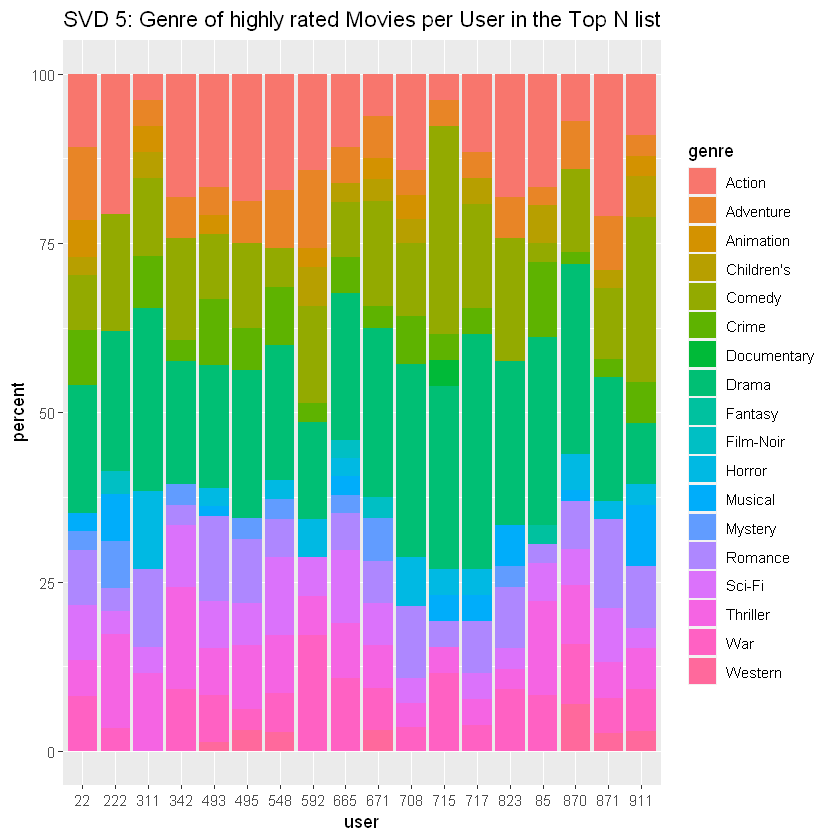

In [140]:
ggplot(SVD_10_top_n_genre, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "SVD 5: Genre of highly rated Movies per User in the Top N list")

3. Bestimme pro Kunde den Anteil nach Genres seiner Top-Filme (=Filme, 
welche vom Kunden die besten Bewertungen erhalten haben),

In [185]:
fav_genre_of_users <- function(random_user_idx, MovieLenseData, Movie_Genre, top_rating=4){
    #' @random_user_idx vector with random ints
    #' @param MovieLenseData Movielense data.frame, containing how a user has rated a movie.
    #' @param Movie_Genre melted MovieLenseData, containing at least the genre and the title of a movie
    #' @top_rating min rating to consider a movie a top movie for a user (inclusive)
    #' @param returns a data.frame with the genres of top rated movies by the user. 
    test_user_selected = as(names(as(test_user_selected, 'list')), 'matrix') # Ugly code is beautiful too.
    Movie_Genre$item = Movie_Genre$title
    user_top_genres <- MovieLenseData %>%
        filter(user %in% test_user_selected) %>%
        filter(rating >= top_rating) %>%
        left_join(Movie_Genre, by = "item")  %>%
        group_by(user, genre)  %>%
        summarise(n = n()) %>% 
        mutate(percent =  100 *n/sum(n))
    user_top_genres$TopGenres <- user_top_genres$percent
        #select(user, genre, n)
    return (user_top_genres)
}

In [186]:
fav_genres = fav_genre_of_users(test_user_selected, MovieLense_df, Movie_Genre)

`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


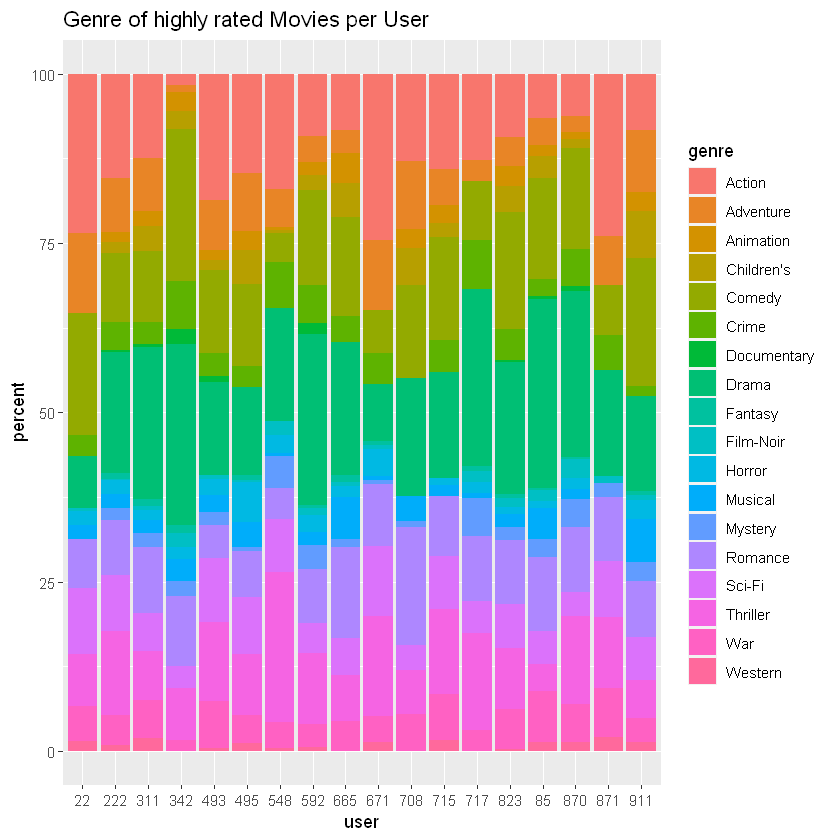

In [187]:
ggplot(fav_genres, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "Genre of highly rated Movies per User")
 #scale_y_continuous(labels = percentage)

4. Vergleiche pro Kunde Top-Empfehlungen und Top-Filmen nach Genres,

In [188]:
all_top_n_genres <- fav_genres %>%
    full_join(IBCF_top_genre, by=c('user', 'genre')) %>%
    full_join(UBCF_cos_top_genre, by=c('user', 'genre')) %>%
    full_join(UBCF_jacc_top_n_genre, by=c('user', 'genre')) %>%
    full_join(SVD_5_top_n_genre, by=c('user', 'genre')) %>%
    full_join(SVD_10_top_n_genre, by=c('user', 'genre')) %>%
    select_at(vars(-ends_with(".y"))) %>%
    select_at(vars(-ends_with(".x"))) 

all_top_n_genres[is.na(all_top_n_genres)] = 0

all_top_n_genres_melted = melt(all_top_n_genres, id.vars = c("user", "genre"), measure.vars = c("TopGenres", "IBCFCos", "UBCFCos", "UBCFJacc", "SVD5", "SVD10"))

In [189]:
head(all_top_n_genres_melted)

user,genre,variable,value
22,Action,TopGenres,23.5897436
22,Adventure,TopGenres,11.7948718
22,Comedy,TopGenres,17.9487179
22,Crime,TopGenres,3.0769231
22,Drama,TopGenres,7.6923077
22,Film-Noir,TopGenres,0.5128205


In [190]:
all_top_n_genres_melted_u22_test <- all_top_n_genres_melted_u22 %>%
    filter(variable=="SVD10")
head(all_top_n_genres_melted_u22_test)

user,genre,variable,value
22,Action,SVD10,10.810811
22,Adventure,SVD10,10.810811
22,Comedy,SVD10,8.108108
22,Crime,SVD10,8.108108
22,Drama,SVD10,18.918919
22,Film-Noir,SVD10,0.000000


In [182]:
all_top_n_genres_melted_u22_test

user,genre,variable,value
22,Action,SVD10,10.810811
22,Adventure,SVD10,10.810811
22,Comedy,SVD10,8.108108
22,Crime,SVD10,8.108108
22,Drama,SVD10,18.918919
22,Film-Noir,SVD10,0.000000
22,Horror,SVD10,0.000000
22,Musical,SVD10,2.702703
22,Romance,SVD10,8.108108
22,Sci-Fi,SVD10,8.108108


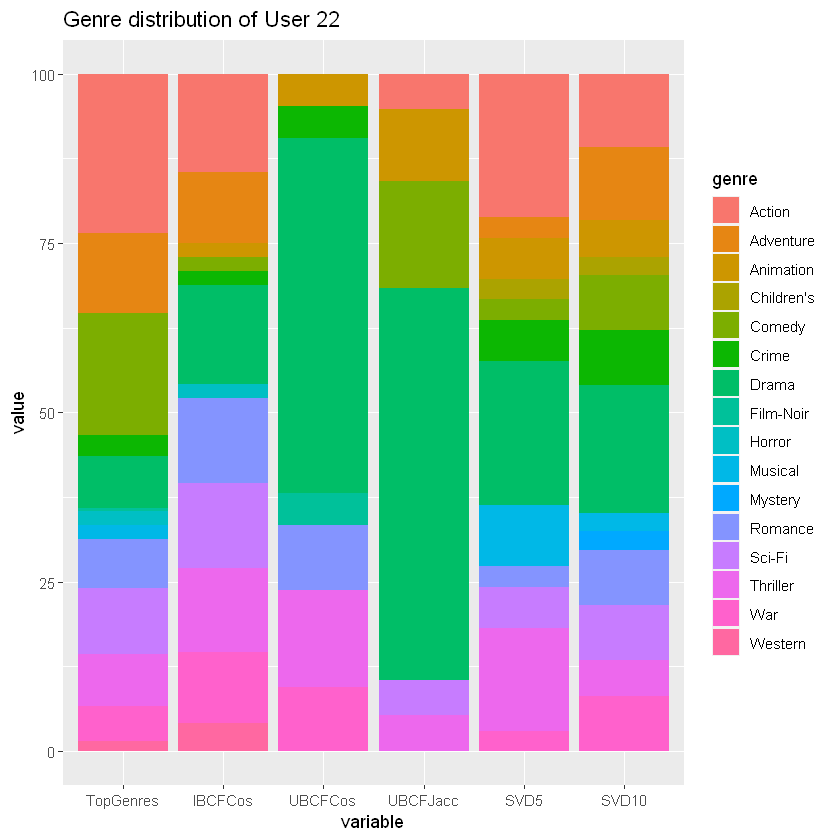

In [193]:
all_top_n_genres_melted_u22 <- all_top_n_genres_melted %>%
    filter(user==22)
ggplot(all_top_n_genres_melted_u22, aes(x = variable, y = value, fill = genre)) +
 geom_col() + labs(title = "Genre distribution of User 22")
 #scale_y_continuous(labels = percentage)

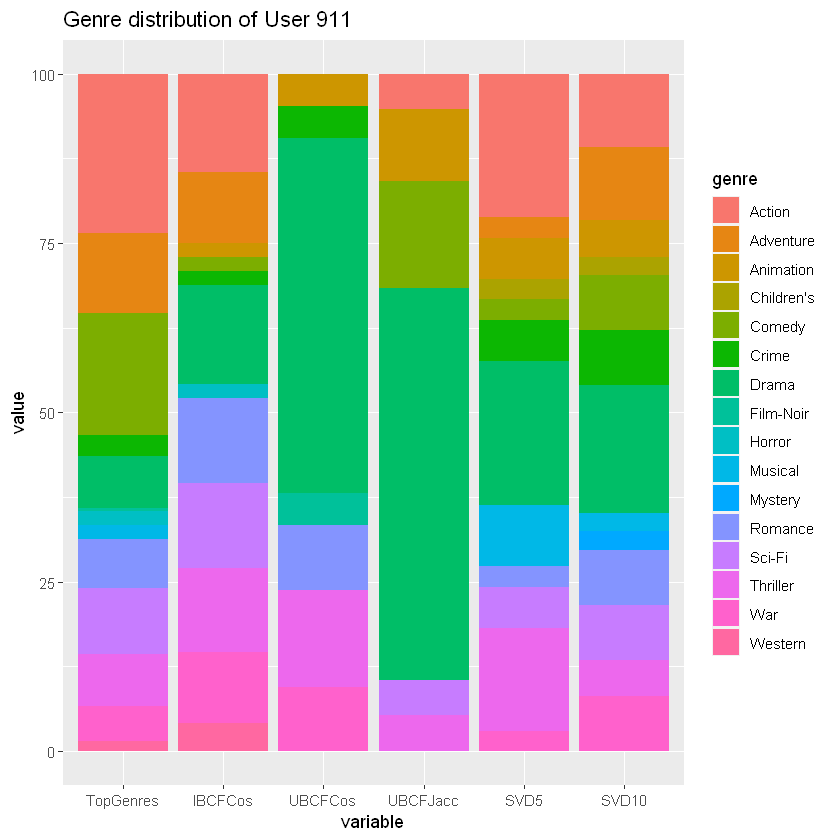

In [195]:
all_top_n_genres_melted_u911 <- all_top_n_genres_melted %>%
    filter(user==911)
ggplot(all_top_n_genres_melted_u22, aes(x = variable, y = value, fill = genre)) +
 geom_col() + labs(title = "Genre distribution of User 911")
 #scale_y_continuous(labels = percentage)

In [219]:
cols = colnames(all_top_n_genres)[c(4:8)]
df <- data.frame(matrix(ncol = length(cols), nrow = 1))
colnames(df) <- cols

In [220]:
df[1, "TopGenres"]

NULL

In [221]:
df

IBCFCos,UBCFCos,UBCFJacc,SVD5,SVD10
NA,NA,NA,NA,NA


In [207]:
calc_genre_similarity <- function(all_top_n_genres, cols){
}

[1] "TopGenres" "IBCFCos"   "UBCFCos"   "UBCFJacc"  "SVD5"      "SVD10"

In [239]:
calc_genre_err <- function(all_top_n_genres, cols){
    #' @all_top_n_genres dataframe containing the top genres from top rated movies of users and predictions done by different models.
    #' @cols Column names with the genre distributions of predictions.
    #' @param returns a data.frame with the absolute error of genre difference between the user rated movies and the predicted movies.
    df <- data.frame(matrix(ncol = length(cols), nrow = 1))
    colnames(df) <- cols
    top_genres <- all_top_n_genres$TopGenres
    for (col in cols){
        df_tmp = sum(abs(top_genres - all_top_n_genres[,col])) / length(top_genres)
        df[1, col] <- df_tmp
    }
    return (df)
}

In [241]:
genre_error = calc_genre_err(all_top_n_genres, colnames(all_top_n_genres)[c(4:8)])

In [245]:
melt(genre_error)

No id variables; using all as measure variables


variable,value
IBCFCos,3.631587
UBCFCos,4.301079
UBCFJacc,5.316868
SVD5,3.220665
SVD10,3.303796


No id variables; using all as measure variables


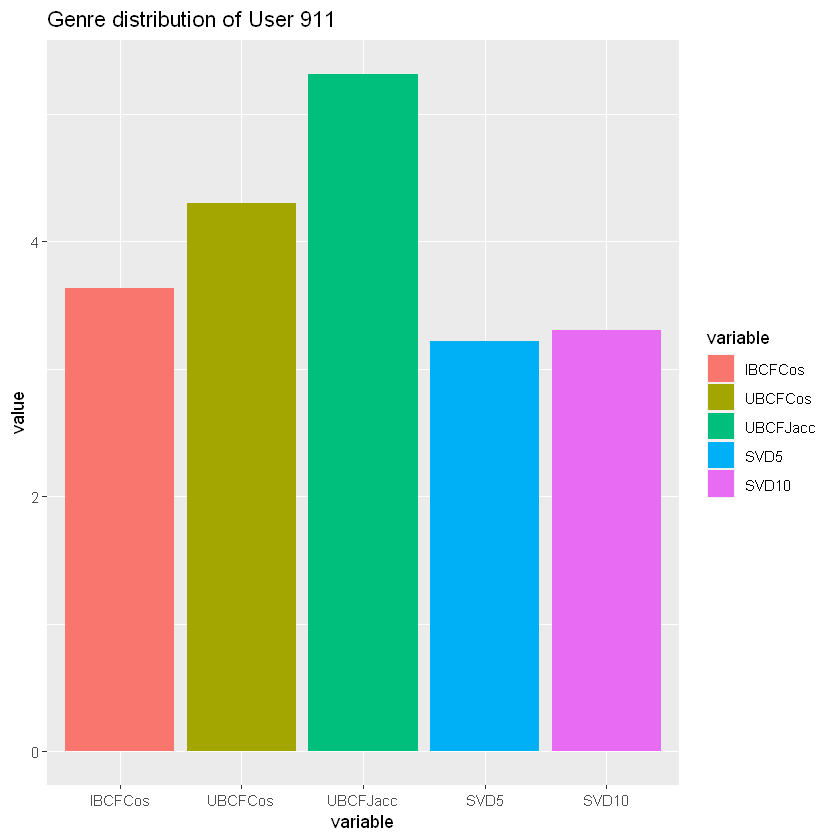

In [243]:
ggplot(melt(genre_error), aes(x = variable, y = value, fill = variable)) +
 geom_col() + labs(title = "Genre distribution of User 911")
 #scale_y_continuous(labels = percentage)

5.Definiere eine Qualitätsmetrik für Top-N Listen und teste sie.

No id variables; using all as measure variables


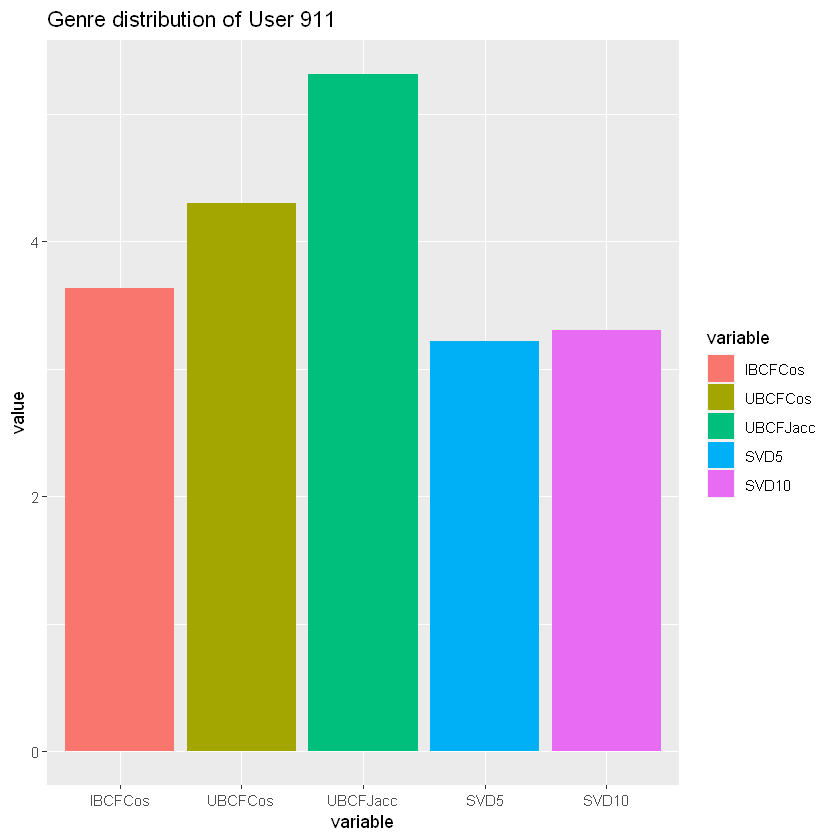

In [246]:
ggplot(melt(genre_error), aes(x = variable, y = value, fill = variable)) +
 geom_col() + labs(title = "Genre distribution of User 911")
 #scale_y_continuous(labels = percentage)